In [107]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.regularizers import L2
from time import time

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# Set the seeds for reproducibility
from numpy.random import seed
from tensorflow.random import set_seed
seed_value = 1234578790
seed(seed_value)
set_seed(seed_value)

In [159]:
train_folder = '../data/train'
test_folder = '../data/test'

x_img_size = 16
y_img_size = 256

In [155]:
def image_file_iterator(root):
    for subdir, dirs, files in os.walk(root):
        for file in files:
            if (file.endswith('.png')):
                yield os.path.join(subdir, file)

        for dir in dirs:
            for file in image_file_iterator(dir):
                yield os.path.join(subdir, file)

def scale_and_normalize(img, size):
    if (img.shape[0] != size or img.shape[1] != size):
        img = cv2.resize(img, (size, size))
    return img / 255

def datagen(data_root, batch_size):
    file_provider = image_file_iterator(data_root)
    files_pending = True
    while(files_pending):
        x_batch = []
        y_batch = []

        for ii in range(batch_size):
            fpath = next(file_provider, '') 

            if (fpath != ''):
                # Load source image
                src_img = cv2.imread(fpath)
                src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)
                
                # Normalization
                #src_img = src_img / 255

                # Make X
                x_img = cv2.cvtColor(src_img, cv2.COLOR_RGB2GRAY)
                x_img = scale_and_normalize(x_img, x_img_size)
                x_batch.append(x_img)

                # Make Y
                y_img = scale_and_normalize(src_img, y_img_size)
                y_batch.append(y_img)

            else:
                files_pending = False
                break
        
        if len(x_batch) > 0:
            yield np.array(x_batch), np.array(y_batch)

In [160]:
# Let's see the number of data
train_set_len = sum(1 for _ in image_file_iterator(train_folder))
test_set_len = sum(1 for _ in image_file_iterator(test_folder))

print(train_set_len)
print(test_set_len)

# Also do a smoke test for datagen 
# for 1000 test images we expecting 1000 batches (when batch_size = 1)
if (sum(1 for _ in datagen(test_folder, batch_size=1)) != test_set_len):
    print('datagen failure!')

# for 1000 test images we expecting 500 batches (when batch_size = 2)
if (sum(1 for _ in datagen(test_folder, 2)) != test_set_len / 2):
    print('datagen failure!')



65284
1000


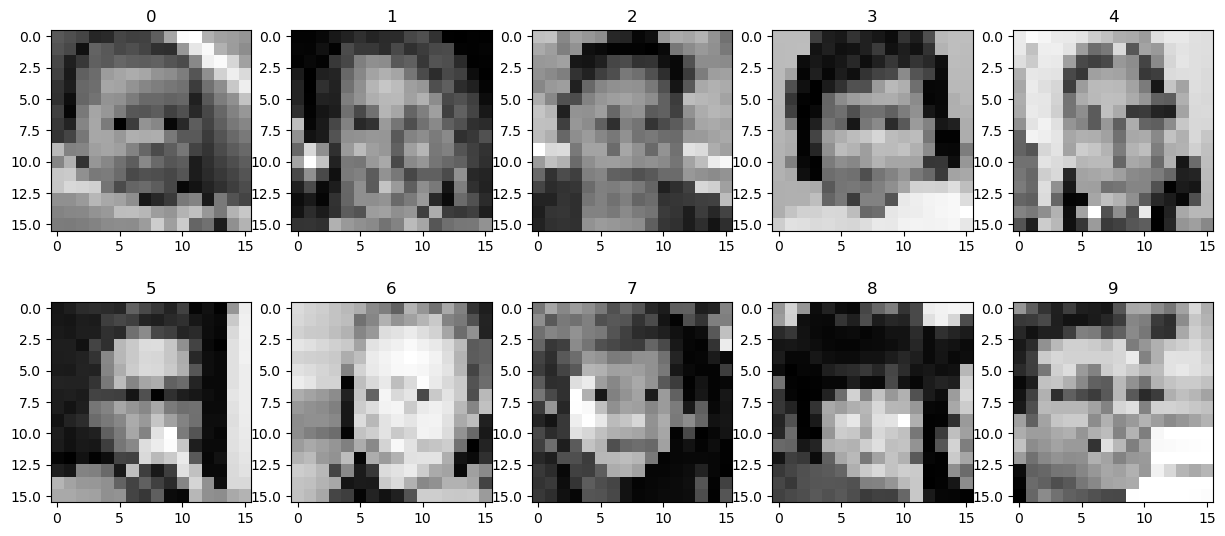

In [161]:
# test datagen
batch = next(datagen(train_folder, 10))

x_train_batch = batch[0]
y_train_batch = batch[1]

# Show x_train
for ii in range(x_train_batch.shape[0]):
    plt.subplot(3,5,ii+1), plt.imshow(x_train_batch[ii], cmap = 'gray'), plt.title(ii)

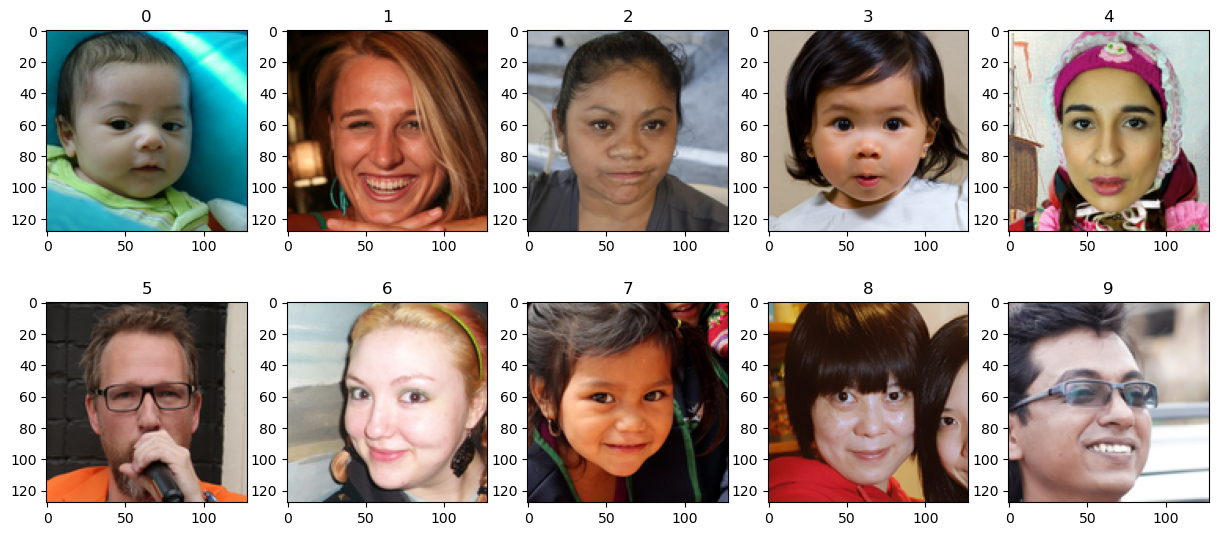

In [112]:
# Show y_train
for ii in range(y_train_batch.shape[0]):
    plt.subplot(3,5,ii+1), plt.imshow(y_train_batch[ii]), plt.title(ii)

In [166]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }

scale_ratio = y_img_size / x_img_size

inputs = Input(shape=(x_img_size, x_img_size, 1))

#net = Conv2D(128, 13, **conv_args)(inputs)
#net = MaxPooling2D(2)(net)
net = Conv2D(64, 5, **conv_args)(inputs)
net = Conv2D(64, 3, **conv_args)(net)
net = Dropout(0.1)(net)
net = Conv2D(32, 3, **conv_args)(net)
net = Conv2D(3 * (scale_ratio ** 2), 3, **conv_args)(net)
net = Dropout(0.2)(net)
outputs = tf.nn.depth_to_space(net, scale_ratio)


model = Model(inputs, outputs)
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 16, 16, 1)]       0         
                                                                 
 conv2d_40 (Conv2D)          (None, 16, 16, 64)        1664      
                                                                 
 conv2d_41 (Conv2D)          (None, 16, 16, 64)        36928     
                                                                 
 dropout_20 (Dropout)        (None, 16, 16, 64)        0         
                                                                 
 conv2d_42 (Conv2D)          (None, 16, 16, 32)        18464     
                                                                 
 conv2d_43 (Conv2D)          (None, 16, 16, 768)       221952    
                                                                 
 dropout_21 (Dropout)        (None, 16, 16, 768)       0  

In [167]:
# Train the network
epochs = 1
batch_size = 128
steps_per_epoch = train_set_len / batch_size + 1

print(steps_per_epoch)

src = datagen(train_folder, batch_size)

x_test, y_test = next(datagen(test_folder, test_set_len))

print(len(x_test))

#validation_data = (x_test), np.array(y_test))

model.compile(loss="mean_squared_error", optimizer="adam", metrics=["accuracy"])
#history = model.fit(src, steps_per_epoch=steps_per_epoch, epochs=epochs, validation_data=validation_data)
history = model.fit(src, epochs=epochs, validation_data=(x_test, y_test))

511.03125
1000
511/511 [==============================] - 543s 1s/step - loss: 4454.3428 - accuracy: 0.6229 - val_loss: 1383.2477 - val_accuracy: 0.7631


1/1 [==============================] - 0s 297ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

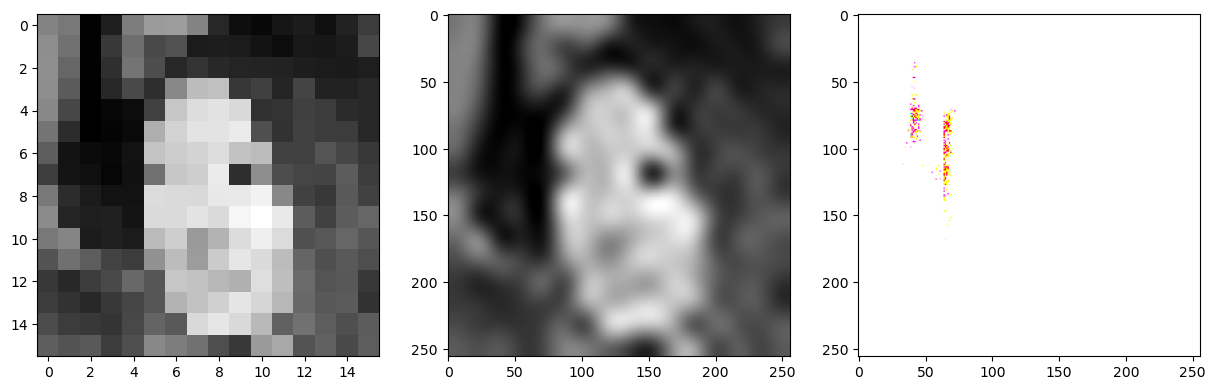

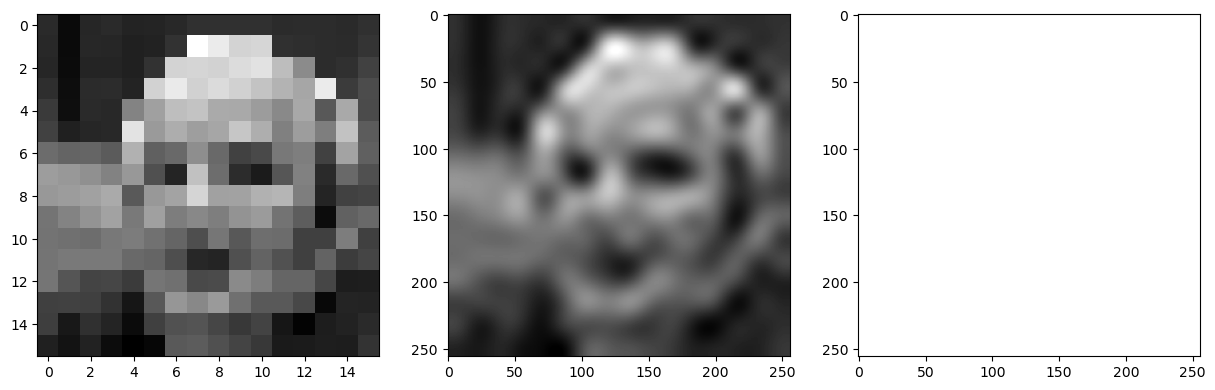

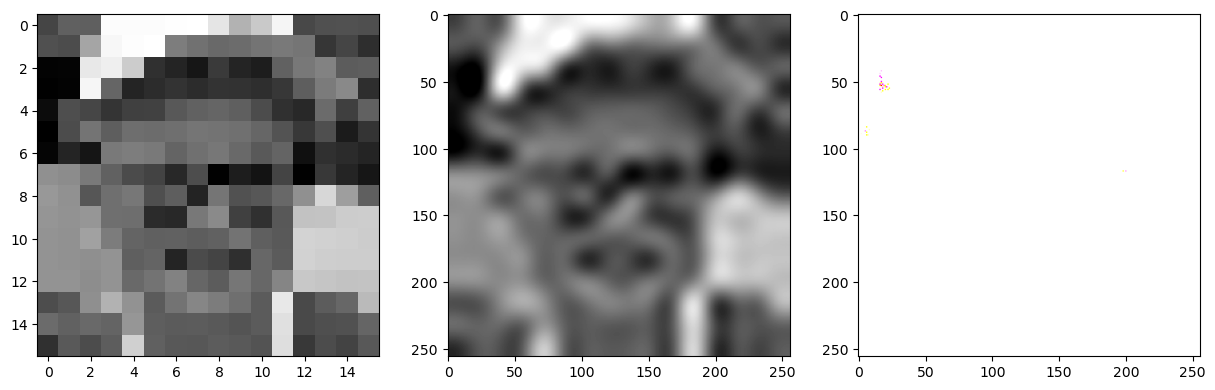

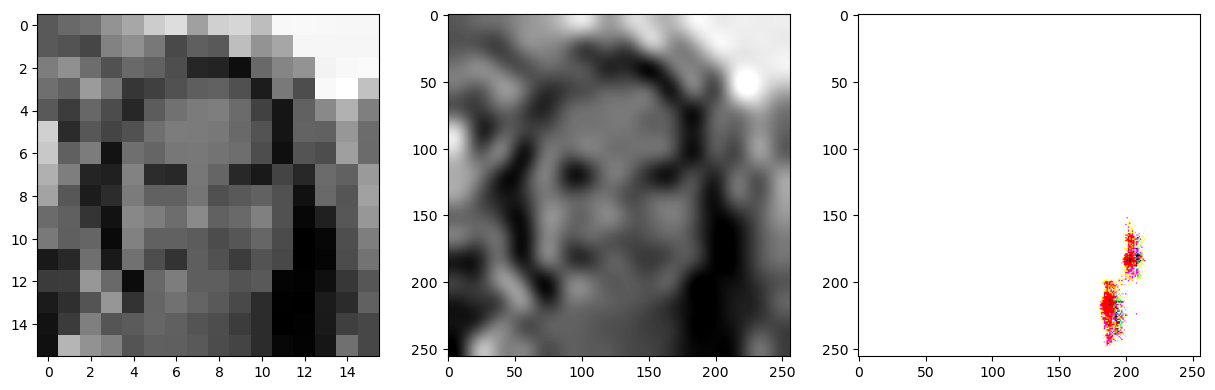

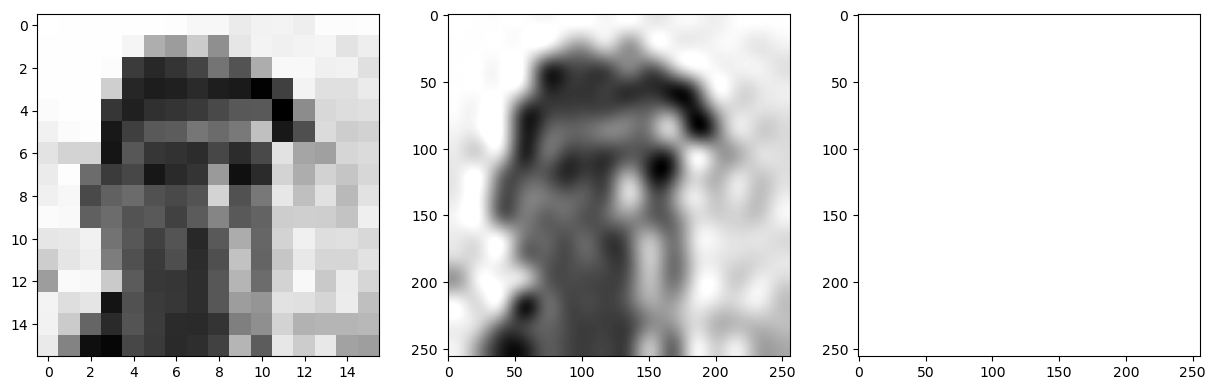

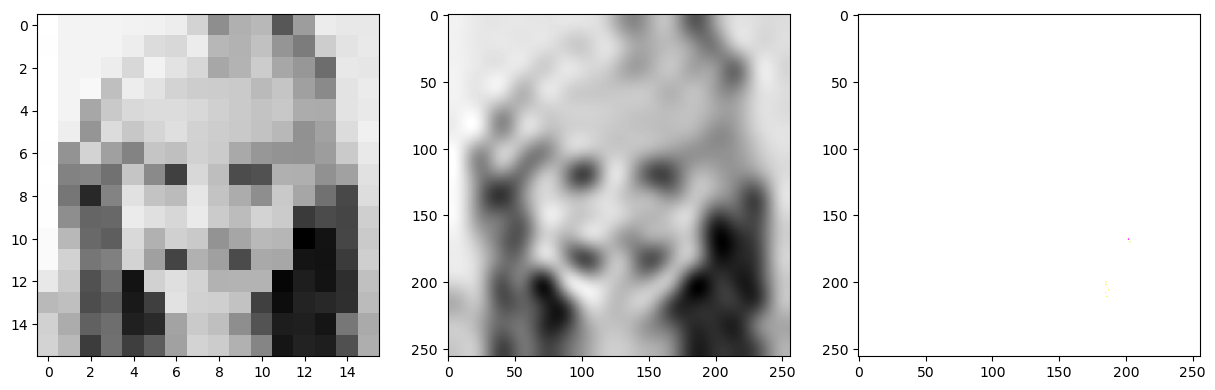

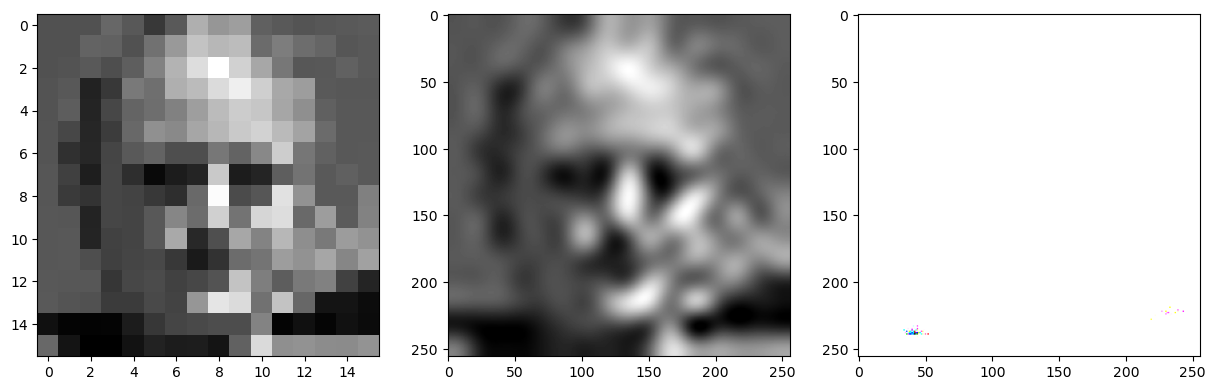

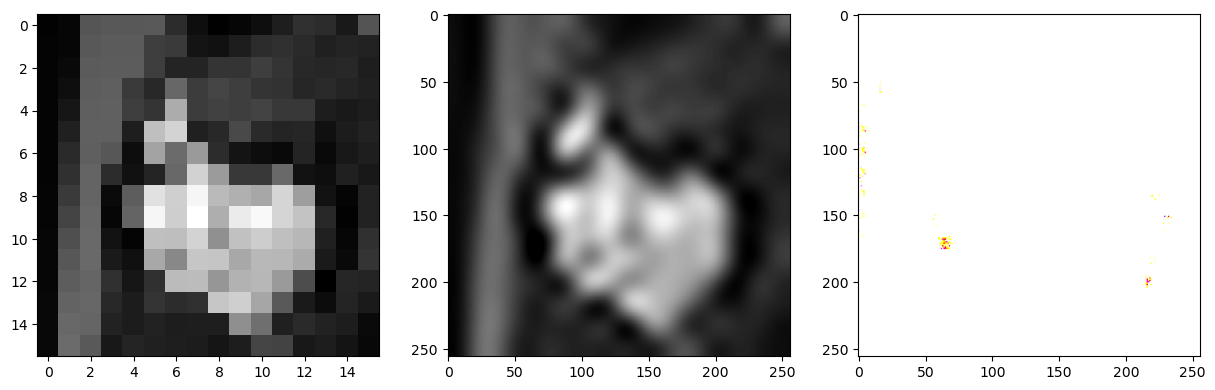

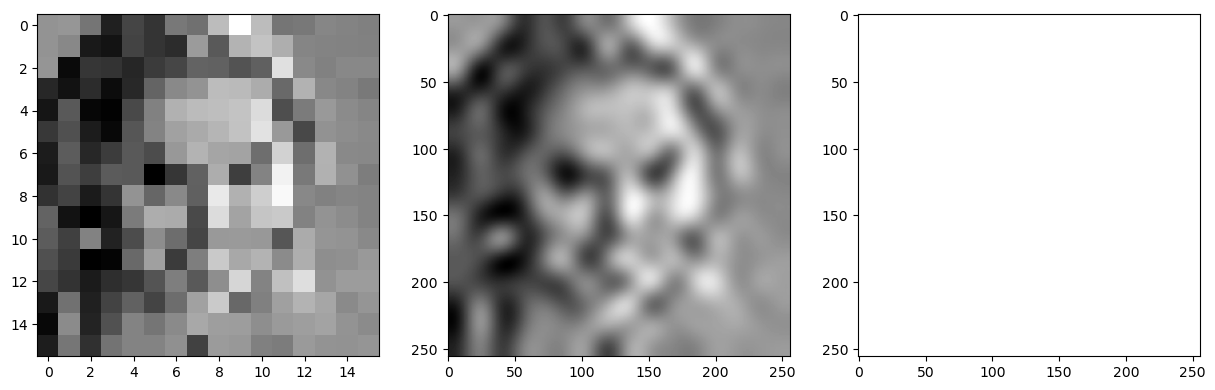

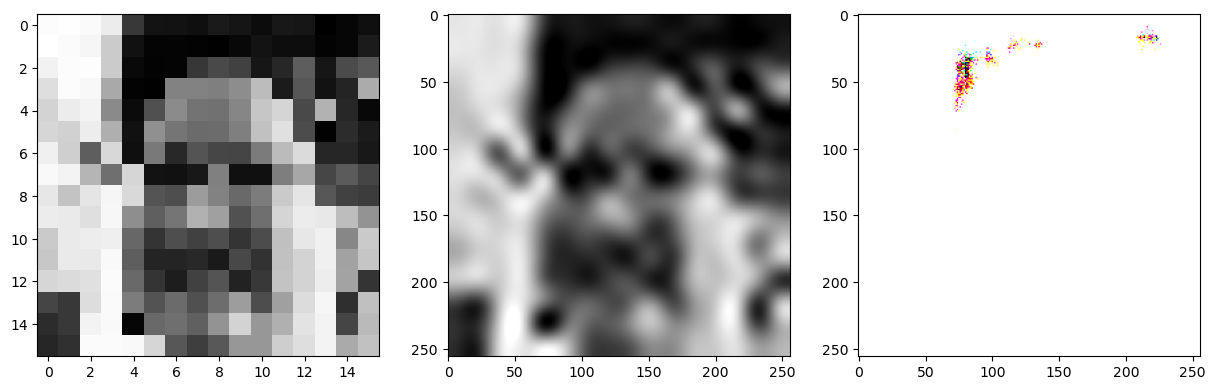

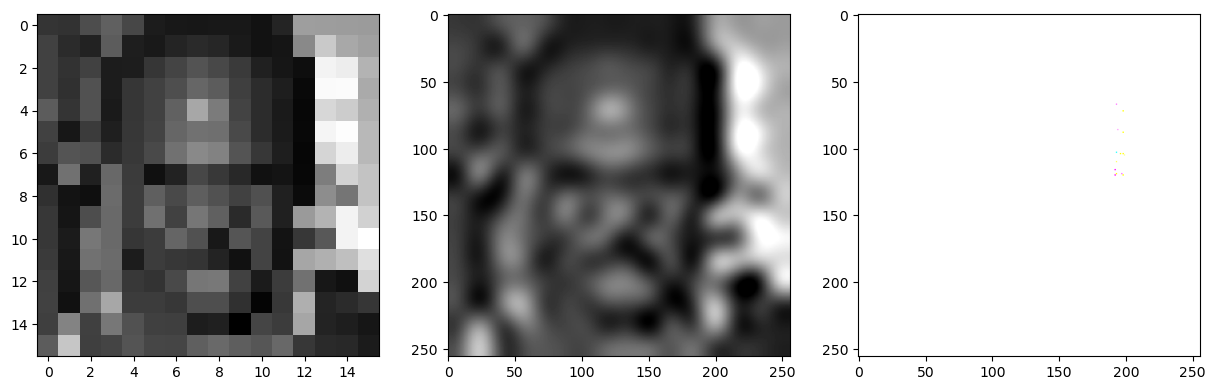

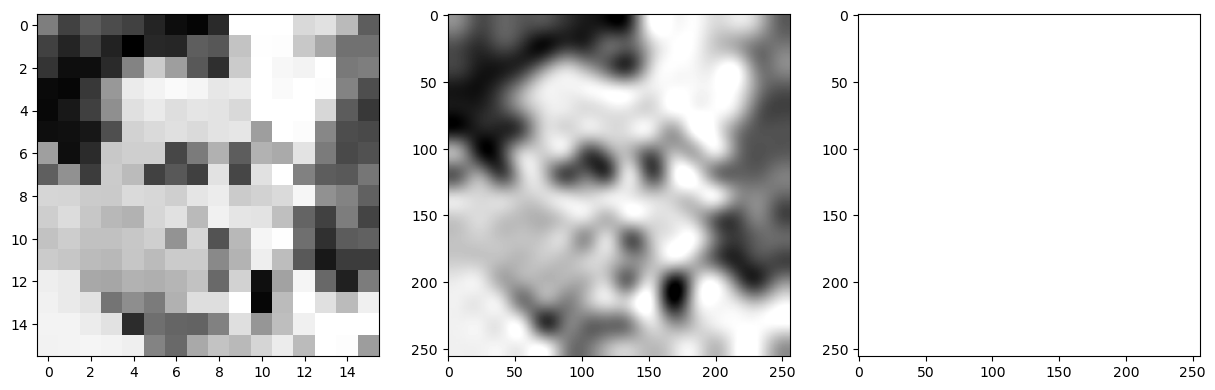

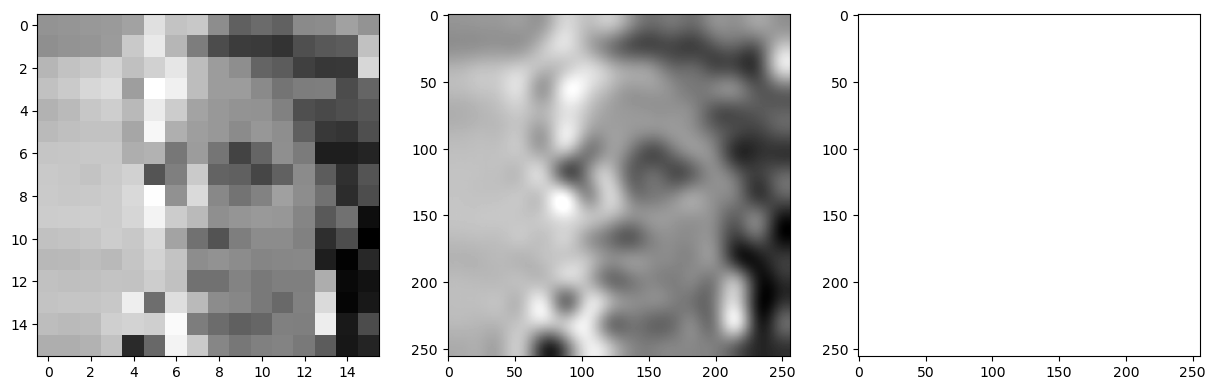

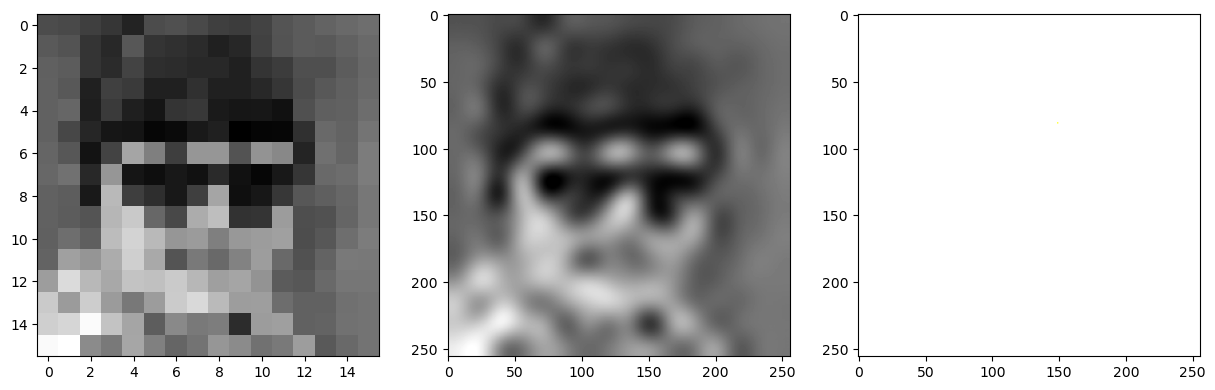

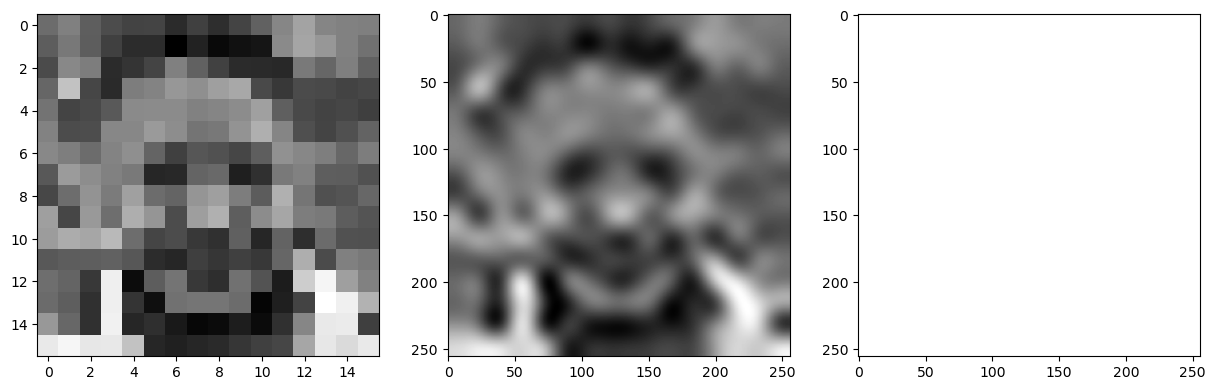

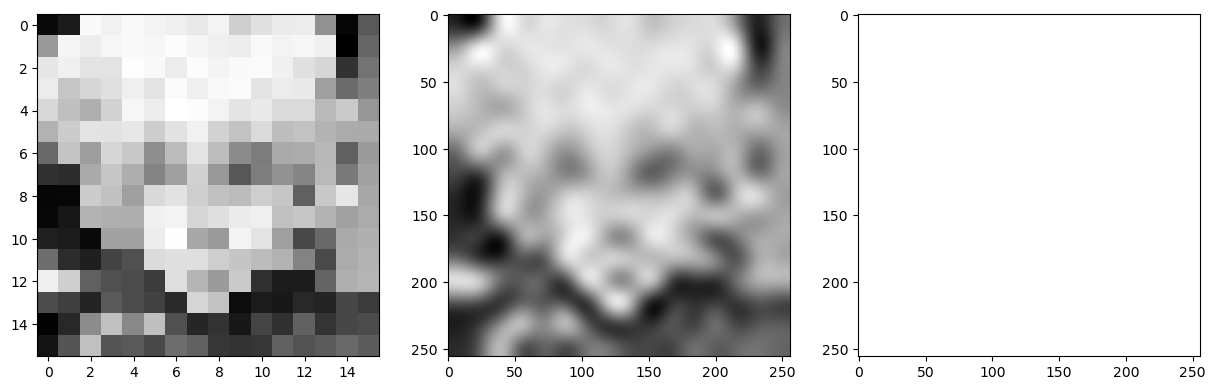

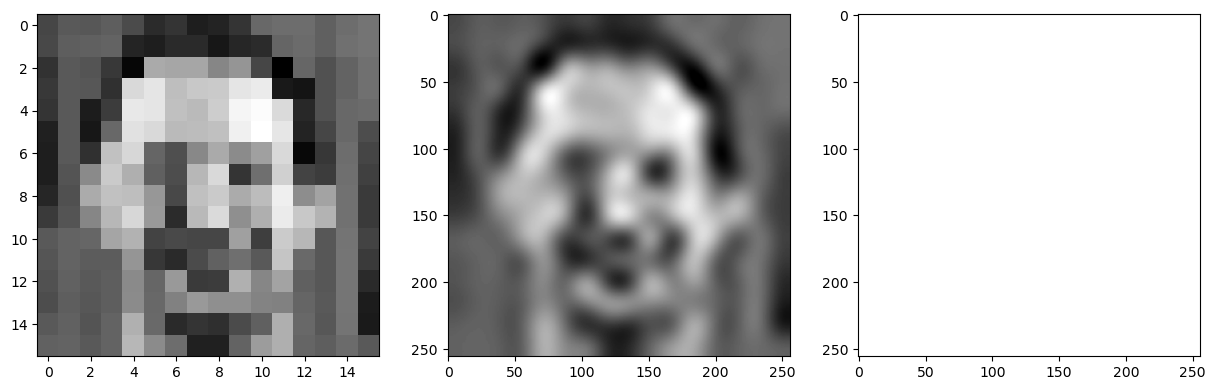

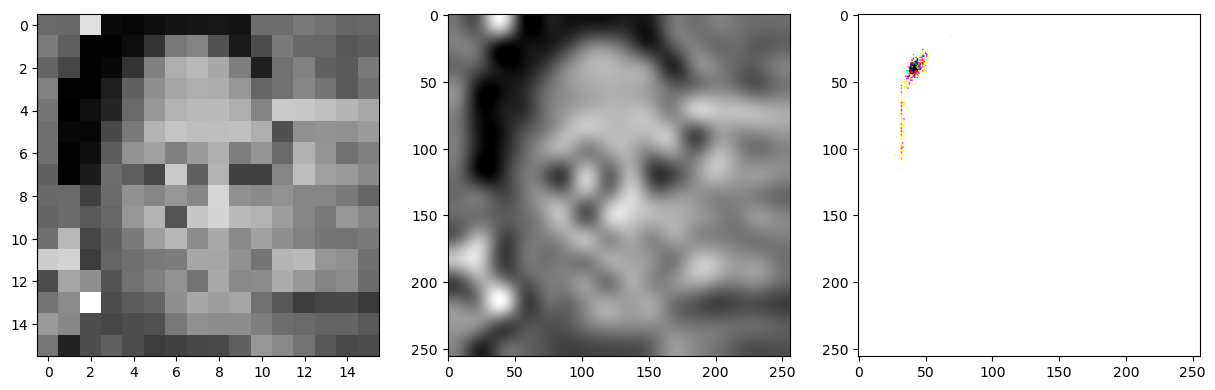

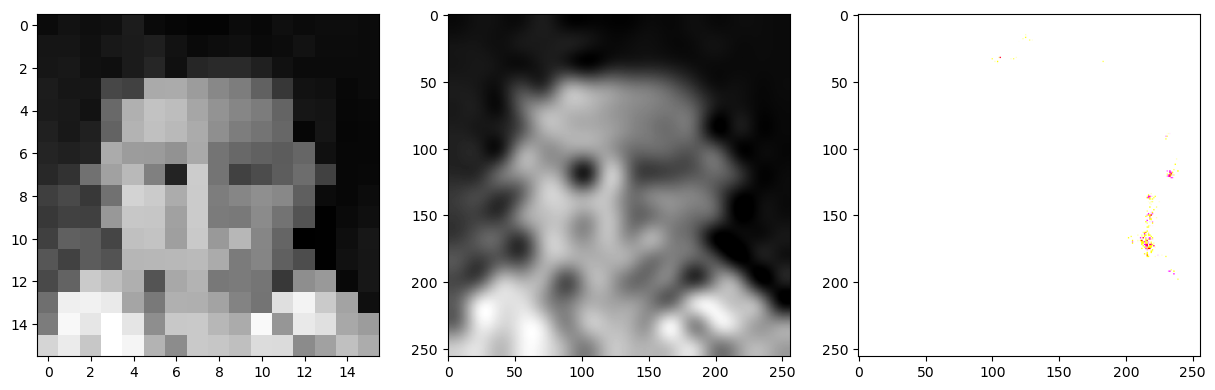

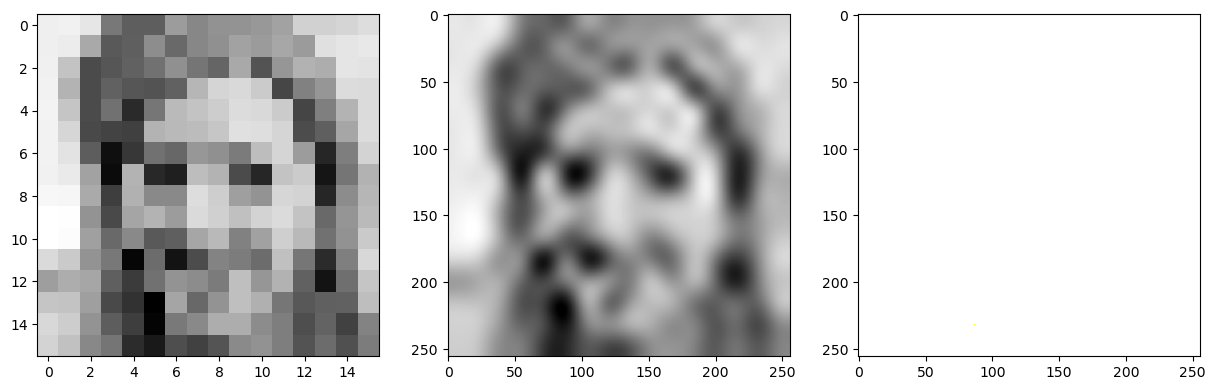

In [168]:
test_range = 20

batch = next(datagen(test_folder, test_range))

x_test = batch[0]

y_test = model.predict(x_test)

#img = np.array(y_test[9])

#plt.imshow(img)

#for ii in range(0, test_range-1):
#    plt.subplot(10, 2, 1), plt.imshow(x_test[ii], cmap='gray')
#    plt.subplot(10, 2, 2), plt.imshow(np.array(y_test[ii]))

for ii in range(test_range):
    f, axarr = plt.subplots(1,3)
    axarr[0].imshow(x_test[ii], cmap='gray')
    axarr[1].imshow(cv2.resize(x_test[ii], (y_img_size, y_img_size), interpolation=cv2.INTER_LANCZOS4), cmap='gray')
    axarr[2].imshow(np.array(y_test[ii]))
